# Import Packages

In [3]:
import math
import torch
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import torch.profiler as profiler
from tensorboardX import SummaryWriter
import datetime
import warnings
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from typing import List, Tuple
warnings.filterwarnings('ignore')

# Retreive Data

In [4]:
parquet_file = '../data/D16.04.25G04.24.16.26.19.parquet'
df_by_store = pd.read_parquet(parquet_file)
df_by_store

,date,resource_id,earnings
0,2016-04-25,1,204091.599570
1,2016-04-25,2,145476.503988
2,2016-04-25,3,83537.048125
3,2016-04-25,4,50666.284179
4,2016-04-25,5,40513.241215
...,...,...,...
0,2021-04-23,1,49277.046649
1,2021-04-23,2,119250.287098
2,2021-04-23,3,78128.432672
3,2021-04-23,4,20863.805292


In [5]:
writer = SummaryWriter('logs')

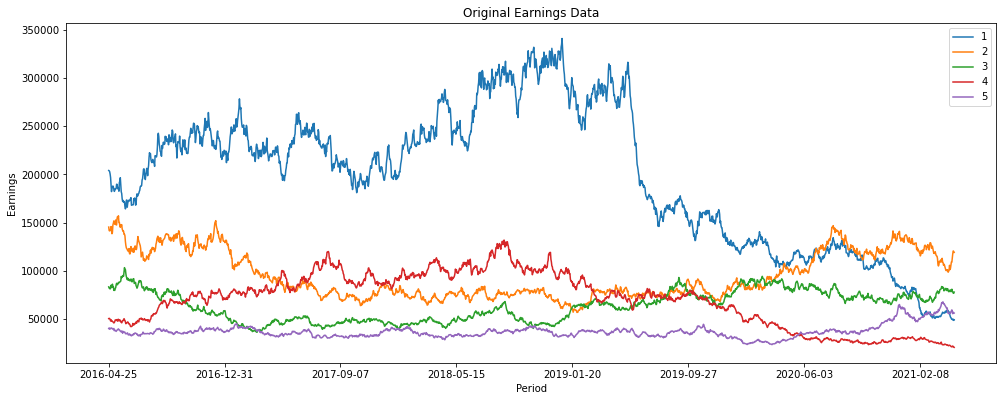

In [6]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_by_store.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')

plt.savefig('logs/earnings_data.png')

## Start with Aggregate Data

In [7]:
# get cumulative earnings into sequence
df_stores_total_daily = df_by_store.groupby(by=['date']).sum()['earnings'].reset_index()
df_stores_total_daily.head()

,date,earnings
0,2016-04-25,524284.677077
1,2016-04-26,518631.893148
2,2016-04-27,517662.792609
3,2016-04-28,513351.767304
4,2016-04-29,511950.989776


# Regression features

In [8]:
df_stores_total_daily['Year'] = pd.to_datetime(df_stores_total_daily['date']).dt.year
df_stores_total_daily['Month'] = pd.to_datetime(df_stores_total_daily['date']).dt.month
df_stores_total_daily['WeekOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day.apply(lambda day: math.ceil(int(day)/7))
df_stores_total_daily['WeekOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.week
df_stores_total_daily['DayOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day
df_stores_total_daily['DayOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.dayofyear

df_stores_total_daily.head()

,date,earnings,Year,Month,WeekOfMonth,WeekOfYear,DayOfMonth,DayOfYear
0,2016-04-25,524284.677077,2016,4,4,17,25,116
1,2016-04-26,518631.893148,2016,4,4,17,26,117
2,2016-04-27,517662.792609,2016,4,4,17,27,118
3,2016-04-28,513351.767304,2016,4,4,17,28,119
4,2016-04-29,511950.989776,2016,4,5,17,29,120


In [9]:
# get cumulative earnings into sequence
df_stores_total_monthly = df_stores_total_daily.groupby(by=['Month','Year']).sum()['earnings'].reset_index()
df_stores_total_monthly.head()

,Month,Year,earnings
0,1,2017,1.613458e+07
1,1,2018,1.460313e+07
2,1,2019,1.651412e+07
3,1,2020,1.173956e+07
4,1,2021,1.151629e+07


Text(0, 0.5, 'Earnings')

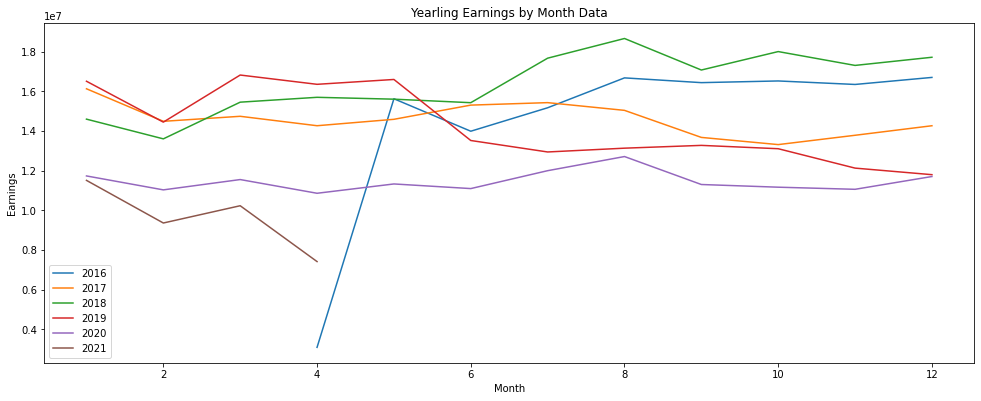

In [10]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_stores_total_monthly.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x='Month', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Yearling Earnings by Month Data')
plt.xlabel('Month')
plt.ylabel('Earnings')

# Cumulative Earnings Data

Text(0, 0.5, 'Earnings')

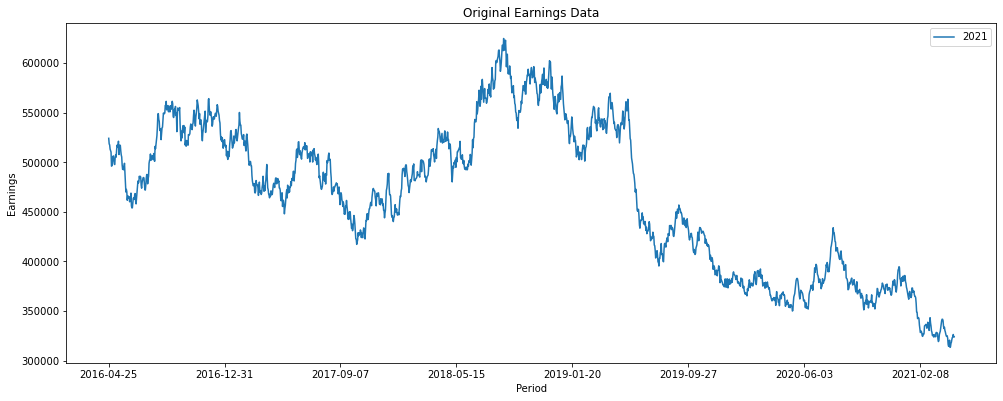

In [11]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = df_stores_total_daily.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')


# Split Data

In [12]:
#split data
data_all = df_stores_total_daily.earnings
sz = len(data_all)
test_sz = math.floor(.2 * sz)
sz, test_sz

(1825, 365)

In [13]:
train_data = data_all[:-test_sz]
test_data = data_all[-test_sz:]
len(train_data)+len(test_data), len(test_data)

(1825, 365)

In [14]:
msmin, msmax = train_data.min(), train_data.max()
print(f'Min: {msmin}, Max: {msmax}')
train_data_scaled = (train_data - msmin) / (msmax - msmin)

Min: 355379.73648441746, Max: 625030.780834687


Text(0, 0.5, 'Earnings')

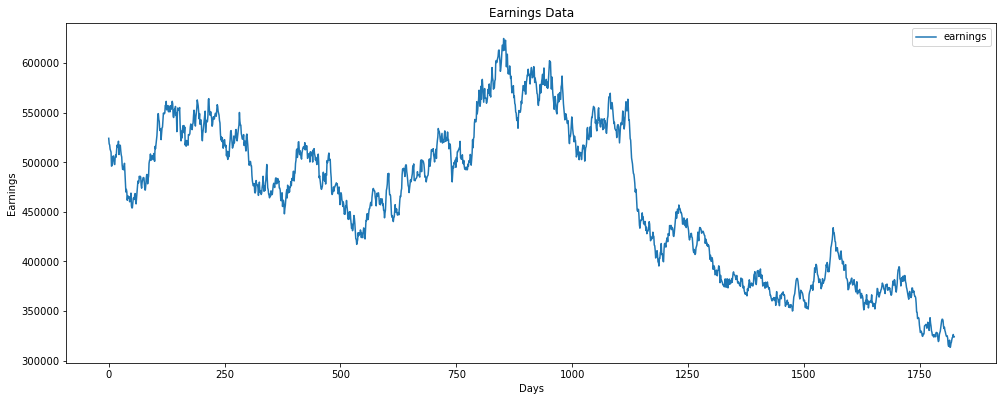

In [15]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = data_all.plot(ax=ax, kind='line', x='days', y='earnings')
leg = ax.legend()
plt.title(f'Earnings Data')
plt.xlabel('Days')
plt.ylabel('Earnings')



# Create Dataset with Lookback

In [16]:
# lookback window
window = 100

In [17]:
class SeqDataset(Dataset):
    def __init__(self, sequence: torch.Tensor, window: int) -> None:
        self.sz = len(sequence) - window
        self.win = window
        self.seq = sequence

    def __len__(self) -> int:
        return self.sz

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        e = i + self.win
        return self.seq[i:e], self.seq[e:e+1]

    def scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence - min) / (max - min)

    def inverse_scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence*(max - min)) + min



In [18]:
# min/max for scaling
cmin, cmax = data_all.min(), data_all.max()
print(f'{cmin} to {cmax}')
metadata = { 
    "min": float(cmin), 
    "max": float(cmax), 
    "window": window 
}
# scale
data_all = SeqDataset.scale(data_all, cmin, cmax)
# data split
test_sz = math.floor(0.20 * len(data_all))
train_data = torch.FloatTensor(data_all[:-test_sz])
val_data = torch.FloatTensor(data_all.to_numpy()[-test_sz:])
# create sequence datasets
train_dataset = SeqDataset(train_data, window)
val_dataset = SeqDataset(val_data, window)

313315.7295598695 to 625030.780834687


In [19]:
trainloader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers= 4, shuffle = True)

# Model

In [20]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [33]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x.view(-1, x.size(1), 1), (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [34]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [35]:
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
        ],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs/test',"worker4"),
    record_shapes=True
) as p:


    for step, data in enumerate(trainloader):
        inputs, labels = data[0].to(device=device), data[1].to(device=device)
        y_train_pred = model(inputs)
        loss = criterion(y_train_pred, labels)
        print("Step ", step, "MSE: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar('GRU Training Loss', loss.item(), step)
        p.step()

Step  0 MSE:  0.2757839560508728
Step  1 MSE:  0.06288295984268188
Step  2 MSE:  0.060327015817165375
Step  3 MSE:  0.08431142568588257
Step  4 MSE:  0.030610959976911545
Step  5 MSE:  0.03206373751163483
Step  6 MSE:  0.055573470890522
Step  7 MSE:  0.04556620866060257
Step  8 MSE:  0.04718047380447388
Step  9 MSE:  0.036904171109199524
Step  10 MSE:  0.023303862661123276
Step  11 MSE:  0.02057073637843132
Step  12 MSE:  0.018201686441898346
Step  13 MSE:  0.028721002861857414
Step  14 MSE:  0.022617902606725693
Step  15 MSE:  0.019859708845615387
Step  16 MSE:  0.013775489293038845
Step  17 MSE:  0.011558009311556816
Step  18 MSE:  0.012998035177588463
Step  19 MSE:  0.010924477130174637
Step  20 MSE:  0.012626261450350285
Step  21 MSE:  0.009541110135614872


# Model Performance

In [39]:
def predict(seq: List[float], window: int, lookbehind: int, lookahead: int) -> List[float]:
    overlap = []
    predixn = seq[-window:]
    model.eval()
    with torch.no_grad():
        # get lookbehind period (overlap)
        for i in reversed(range(1, lookbehind+1)):
            x = torch.FloatTensor(seq[-window-i:-i]).view(1, -1).to(device)
            y = model(x)
            overlap.append(y.detach().item())
        # begin lookahead period (predictions)
        for i in range(lookahead):
            x = torch.FloatTensor(predixn[-window:]).view(1, -1).to(device)
            y = model(x)
            predixn.append(y.detach().item())
    return overlap + predixn[-lookahead:]

In [42]:
#plot simulation
sequence = val_dataset.seq #validation sequence
# caluate lookback and forward
behind = math.floor(len(sequence) / 2)
forward = math.floor(behind / 2)
# predict
p_seq = predict(list(sequence), window, behind, forward)
# inverse scale
p_seq = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), cmin, cmax)
r_seq = SeqDataset.inverse_scale(torch.FloatTensor(sequence), cmin, cmax)
# create indices
seq_size = sequence.size(0)
#print(seq_size)
actual_range = [i for i in range(seq_size)]
#print(actual_range)
pred_range = [i for i in range(seq_size-behind-1,seq_size+forward-1)]
#print(pred_range)


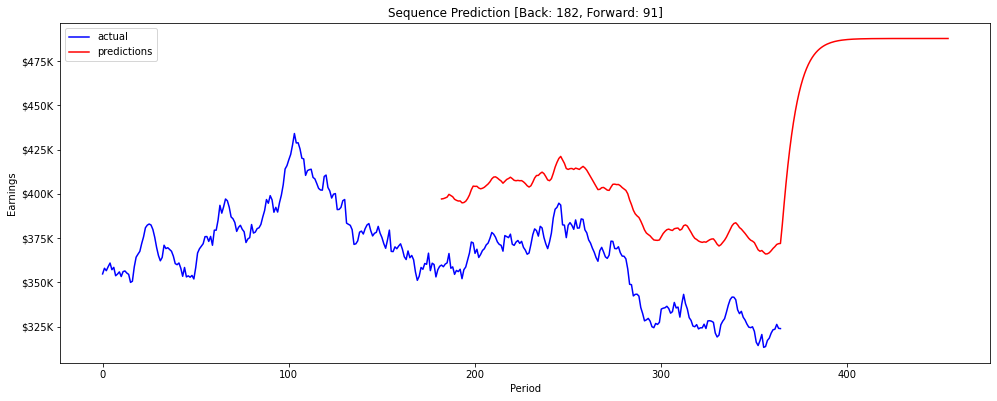

In [44]:
# plot predictions over actuals
import matplotlib.ticker as tick
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax.plot(actual_range, r_seq, color='blue', label='actual')
ax.plot(pred_range, p_seq, color='red', label='predictions')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
plt.xlabel('Period')
plt.ylabel('Earnings')
# save image
plt.savefig('logs/validation_data.png', dpi=96)

In [ ]:
writer.close()